# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

ToDo:
- Find colored dataset to train on

In [1]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
image_size  = 28
autoencoder_depth = 10
dropout = 0.1
channels = 1

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], image_size, image_size, channels))
x_test = np.reshape(x_test, (x_test.shape[0], image_size, image_size, channels))
x_train.shape

(60000, 28, 28, 1)

## Variational Autoencoder

In [30]:
def EncoderBlock():
    def apply(x):
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
        return encoded
    
    return apply

def DecoderBlock():
    def apply(x):
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3, 3), activation='relu')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        return decoded
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(4, 4, 8))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [31]:
class VAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock()(input_image)
        z_mean = layers.Conv2D(8, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(8, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(4, 4, 8))
        decoded = DecoderBlock()(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [ ]:
vae = VAE()
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=200, batch_size = 512)

In [115]:
encoded_images = vae.encode(x_train[0 : batch_size])
batch_size = 512

for i in range(1, int(x_train.shape[0] / batch_size)):
    encoded = vae.encode(x_train[i*batch_size : i * batch_size + batch_size])
    encoded_images = tf.concat([encoded_images, encoded], axis=0)

encoded_images.shape

TensorShape([59904, 4, 4, 8])

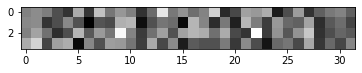

In [116]:
plt.imshow(encoded_images[0].numpy().reshape(4, 4 * 8), cmap='gray')

In [117]:
decoded_images = vae.decode(encoded_images[0 : batch_size])
batch_size = 512

for i in range(1, int(x_train.shape[0] / batch_size)):
    decoded = vae.decode(encoded_images[i*batch_size : i * batch_size + batch_size])
    decoded_images = tf.concat([decoded_images, decoded], axis=0)

decoded_images.shape

TensorShape([59904, 28, 28, 1])

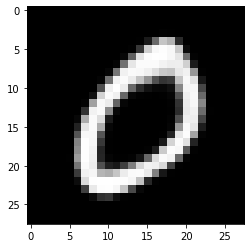

In [119]:
plt.imshow(decoded_images[1].numpy().reshape(28, 28), cmap='gray')

## Denoising U-Net

In [83]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# Architecture.
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

In [84]:
def diffusion_schedule(diffusion_times):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [85]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

In [86]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, (1, 1))(x)
            
        x = layers.Conv2D(width, (3, 3), padding='same', activation=keras.activations.swish)(x)
        x = layers.LayerNormalization()(x + residual)
        return x
    
    return apply

In [87]:
def DownBlock(width, block_depth):
    def apply(x):
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
        
    return apply

In [88]:
def UpBlock(width, block_depth):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        return x
    
    return apply

In [89]:
def create_unet(widths, block_depth):
    noisy_images = keras.Input(shape=(4, 4, 8))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=4, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    for width in widths[:-1]:
        x = DownBlock(width, block_depth)(x)

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)(x)

    x = layers.Conv2D(8, kernel_size=1, kernel_initializer="zeros")(x)
    
    unet = keras.Model([noisy_images, noise_variances], x, name="residual_unet")
    unet.compile(optimizer='adam', loss='mean_absolute_error')
    return unet

In [90]:
def train(train_data, model, epochs, batch_size):
    steps_per_epoch = int(train_data.shape[0] / batch_size)
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = train_data[step * batch_size : step * batch_size + batch_size]
            noises = tf.random.normal(shape=(batch_size, 4, 4, 8))
            
            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
        
        print('Epoch ' + str(epoch) + ' completed.')

In [91]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, 4, 4, 8))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2])
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [101]:
unet = create_unet([32, 64, 32], 4)

In [144]:
train(encoded_images, unet, 10000, 512)

Epoch 0 completed.
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.
Epoch 31 completed.
Epoch 32 completed.
Epoch 33 completed.
Epoch 34 completed.
Epoch 35 completed.
Epoch 36 completed.
Epoch 37 completed.
Epoch 38 completed.
Epoch 39 completed.
Epoch 40 completed.
Epoch 41 completed.
Epoch 42 completed.
Epoch 43 completed.
Epoch 44 completed.
Epoch 45 completed.
Epoch 46 completed.
Epoch 47 completed.
Epoch 48 completed.
Epoch 49 completed.
Epoch 50 c

Epoch 396 completed.
Epoch 397 completed.
Epoch 398 completed.
Epoch 399 completed.
Epoch 400 completed.
Epoch 401 completed.
Epoch 402 completed.
Epoch 403 completed.
Epoch 404 completed.
Epoch 405 completed.
Epoch 406 completed.
Epoch 407 completed.
Epoch 408 completed.
Epoch 409 completed.
Epoch 410 completed.
Epoch 411 completed.
Epoch 412 completed.
Epoch 413 completed.
Epoch 414 completed.
Epoch 415 completed.
Epoch 416 completed.
Epoch 417 completed.
Epoch 418 completed.
Epoch 419 completed.
Epoch 420 completed.
Epoch 421 completed.
Epoch 422 completed.
Epoch 423 completed.
Epoch 424 completed.
Epoch 425 completed.
Epoch 426 completed.
Epoch 427 completed.
Epoch 428 completed.
Epoch 429 completed.
Epoch 430 completed.
Epoch 431 completed.
Epoch 432 completed.
Epoch 433 completed.
Epoch 434 completed.
Epoch 435 completed.
Epoch 436 completed.
Epoch 437 completed.
Epoch 438 completed.
Epoch 439 completed.
Epoch 440 completed.
Epoch 441 completed.
Epoch 442 completed.
Epoch 443 com

Epoch 787 completed.
Epoch 788 completed.
Epoch 789 completed.
Epoch 790 completed.
Epoch 791 completed.
Epoch 792 completed.
Epoch 793 completed.
Epoch 794 completed.
Epoch 795 completed.
Epoch 796 completed.
Epoch 797 completed.
Epoch 798 completed.
Epoch 799 completed.
Epoch 800 completed.
Epoch 801 completed.
Epoch 802 completed.
Epoch 803 completed.
Epoch 804 completed.
Epoch 805 completed.
Epoch 806 completed.
Epoch 807 completed.
Epoch 808 completed.
Epoch 809 completed.
Epoch 810 completed.
Epoch 811 completed.
Epoch 812 completed.
Epoch 813 completed.
Epoch 814 completed.
Epoch 815 completed.
Epoch 816 completed.
Epoch 817 completed.
Epoch 818 completed.
Epoch 819 completed.
Epoch 820 completed.
Epoch 821 completed.
Epoch 822 completed.
Epoch 823 completed.
Epoch 824 completed.
Epoch 825 completed.
Epoch 826 completed.
Epoch 827 completed.
Epoch 828 completed.
Epoch 829 completed.
Epoch 830 completed.
Epoch 831 completed.
Epoch 832 completed.
Epoch 833 completed.
Epoch 834 com

Epoch 1170 completed.
Epoch 1171 completed.
Epoch 1172 completed.
Epoch 1173 completed.
Epoch 1174 completed.
Epoch 1175 completed.
Epoch 1176 completed.
Epoch 1177 completed.
Epoch 1178 completed.
Epoch 1179 completed.
Epoch 1180 completed.
Epoch 1181 completed.
Epoch 1182 completed.
Epoch 1183 completed.
Epoch 1184 completed.
Epoch 1185 completed.
Epoch 1186 completed.
Epoch 1187 completed.
Epoch 1188 completed.
Epoch 1189 completed.
Epoch 1190 completed.
Epoch 1191 completed.
Epoch 1192 completed.
Epoch 1193 completed.
Epoch 1194 completed.
Epoch 1195 completed.
Epoch 1196 completed.
Epoch 1197 completed.
Epoch 1198 completed.
Epoch 1199 completed.
Epoch 1200 completed.
Epoch 1201 completed.
Epoch 1202 completed.
Epoch 1203 completed.
Epoch 1204 completed.
Epoch 1205 completed.
Epoch 1206 completed.
Epoch 1207 completed.
Epoch 1208 completed.
Epoch 1209 completed.
Epoch 1210 completed.
Epoch 1211 completed.
Epoch 1212 completed.
Epoch 1213 completed.
Epoch 1214 completed.
Epoch 1215

Epoch 1543 completed.
Epoch 1544 completed.
Epoch 1545 completed.
Epoch 1546 completed.
Epoch 1547 completed.
Epoch 1548 completed.
Epoch 1549 completed.
Epoch 1550 completed.
Epoch 1551 completed.
Epoch 1552 completed.
Epoch 1553 completed.
Epoch 1554 completed.
Epoch 1555 completed.
Epoch 1556 completed.
Epoch 1557 completed.
Epoch 1558 completed.
Epoch 1559 completed.
Epoch 1560 completed.
Epoch 1561 completed.
Epoch 1562 completed.
Epoch 1563 completed.
Epoch 1564 completed.
Epoch 1565 completed.
Epoch 1566 completed.
Epoch 1567 completed.
Epoch 1568 completed.
Epoch 1569 completed.
Epoch 1570 completed.
Epoch 1571 completed.
Epoch 1572 completed.
Epoch 1573 completed.
Epoch 1574 completed.
Epoch 1575 completed.
Epoch 1576 completed.
Epoch 1577 completed.
Epoch 1578 completed.
Epoch 1579 completed.
Epoch 1580 completed.
Epoch 1581 completed.
Epoch 1582 completed.
Epoch 1583 completed.
Epoch 1584 completed.
Epoch 1585 completed.
Epoch 1586 completed.
Epoch 1587 completed.
Epoch 1588

Epoch 1916 completed.
Epoch 1917 completed.
Epoch 1918 completed.
Epoch 1919 completed.
Epoch 1920 completed.
Epoch 1921 completed.
Epoch 1922 completed.
Epoch 1923 completed.
Epoch 1924 completed.
Epoch 1925 completed.
Epoch 1926 completed.
Epoch 1927 completed.
Epoch 1928 completed.
Epoch 1929 completed.
Epoch 1930 completed.
Epoch 1931 completed.
Epoch 1932 completed.
Epoch 1933 completed.
Epoch 1934 completed.
Epoch 1935 completed.
Epoch 1936 completed.
Epoch 1937 completed.
Epoch 1938 completed.
Epoch 1939 completed.
Epoch 1940 completed.
Epoch 1941 completed.
Epoch 1942 completed.
Epoch 1943 completed.
Epoch 1944 completed.
Epoch 1945 completed.
Epoch 1946 completed.
Epoch 1947 completed.
Epoch 1948 completed.
Epoch 1949 completed.
Epoch 1950 completed.
Epoch 1951 completed.
Epoch 1952 completed.
Epoch 1953 completed.
Epoch 1954 completed.
Epoch 1955 completed.
Epoch 1956 completed.
Epoch 1957 completed.
Epoch 1958 completed.
Epoch 1959 completed.
Epoch 1960 completed.
Epoch 1961

Epoch 2289 completed.
Epoch 2290 completed.
Epoch 2291 completed.
Epoch 2292 completed.
Epoch 2293 completed.
Epoch 2294 completed.
Epoch 2295 completed.
Epoch 2296 completed.
Epoch 2297 completed.
Epoch 2298 completed.
Epoch 2299 completed.
Epoch 2300 completed.
Epoch 2301 completed.
Epoch 2302 completed.
Epoch 2303 completed.
Epoch 2304 completed.
Epoch 2305 completed.
Epoch 2306 completed.
Epoch 2307 completed.
Epoch 2308 completed.
Epoch 2309 completed.
Epoch 2310 completed.
Epoch 2311 completed.
Epoch 2312 completed.
Epoch 2313 completed.
Epoch 2314 completed.
Epoch 2315 completed.
Epoch 2316 completed.
Epoch 2317 completed.
Epoch 2318 completed.
Epoch 2319 completed.
Epoch 2320 completed.
Epoch 2321 completed.
Epoch 2322 completed.
Epoch 2323 completed.
Epoch 2324 completed.
Epoch 2325 completed.
Epoch 2326 completed.
Epoch 2327 completed.
Epoch 2328 completed.
Epoch 2329 completed.
Epoch 2330 completed.
Epoch 2331 completed.
Epoch 2332 completed.
Epoch 2333 completed.
Epoch 2334

Epoch 2662 completed.
Epoch 2663 completed.
Epoch 2664 completed.
Epoch 2665 completed.
Epoch 2666 completed.
Epoch 2667 completed.
Epoch 2668 completed.
Epoch 2669 completed.
Epoch 2670 completed.
Epoch 2671 completed.
Epoch 2672 completed.
Epoch 2673 completed.
Epoch 2674 completed.
Epoch 2675 completed.
Epoch 2676 completed.
Epoch 2677 completed.
Epoch 2678 completed.
Epoch 2679 completed.
Epoch 2680 completed.
Epoch 2681 completed.
Epoch 2682 completed.
Epoch 2683 completed.
Epoch 2684 completed.
Epoch 2685 completed.
Epoch 2686 completed.
Epoch 2687 completed.
Epoch 2688 completed.
Epoch 2689 completed.
Epoch 2690 completed.
Epoch 2691 completed.
Epoch 2692 completed.
Epoch 2693 completed.
Epoch 2694 completed.
Epoch 2695 completed.
Epoch 2696 completed.
Epoch 2697 completed.
Epoch 2698 completed.
Epoch 2699 completed.
Epoch 2700 completed.
Epoch 2701 completed.
Epoch 2702 completed.
Epoch 2703 completed.
Epoch 2704 completed.
Epoch 2705 completed.
Epoch 2706 completed.
Epoch 2707

Epoch 3035 completed.
Epoch 3036 completed.
Epoch 3037 completed.
Epoch 3038 completed.
Epoch 3039 completed.
Epoch 3040 completed.
Epoch 3041 completed.
Epoch 3042 completed.
Epoch 3043 completed.
Epoch 3044 completed.
Epoch 3045 completed.
Epoch 3046 completed.
Epoch 3047 completed.
Epoch 3048 completed.
Epoch 3049 completed.
Epoch 3050 completed.
Epoch 3051 completed.
Epoch 3052 completed.
Epoch 3053 completed.
Epoch 3054 completed.
Epoch 3055 completed.
Epoch 3056 completed.
Epoch 3057 completed.
Epoch 3058 completed.
Epoch 3059 completed.
Epoch 3060 completed.
Epoch 3061 completed.
Epoch 3062 completed.
Epoch 3063 completed.
Epoch 3064 completed.
Epoch 3065 completed.
Epoch 3066 completed.
Epoch 3067 completed.
Epoch 3068 completed.
Epoch 3069 completed.
Epoch 3070 completed.
Epoch 3071 completed.
Epoch 3072 completed.
Epoch 3073 completed.
Epoch 3074 completed.
Epoch 3075 completed.
Epoch 3076 completed.
Epoch 3077 completed.
Epoch 3078 completed.
Epoch 3079 completed.
Epoch 3080

Epoch 3408 completed.
Epoch 3409 completed.
Epoch 3410 completed.
Epoch 3411 completed.
Epoch 3412 completed.
Epoch 3413 completed.
Epoch 3414 completed.
Epoch 3415 completed.
Epoch 3416 completed.
Epoch 3417 completed.
Epoch 3418 completed.
Epoch 3419 completed.
Epoch 3420 completed.
Epoch 3421 completed.
Epoch 3422 completed.
Epoch 3423 completed.
Epoch 3424 completed.
Epoch 3425 completed.
Epoch 3426 completed.
Epoch 3427 completed.
Epoch 3428 completed.
Epoch 3429 completed.
Epoch 3430 completed.
Epoch 3431 completed.
Epoch 3432 completed.
Epoch 3433 completed.
Epoch 3434 completed.
Epoch 3435 completed.
Epoch 3436 completed.
Epoch 3437 completed.
Epoch 3438 completed.
Epoch 3439 completed.
Epoch 3440 completed.
Epoch 3441 completed.
Epoch 3442 completed.
Epoch 3443 completed.
Epoch 3444 completed.
Epoch 3445 completed.
Epoch 3446 completed.
Epoch 3447 completed.
Epoch 3448 completed.
Epoch 3449 completed.
Epoch 3450 completed.
Epoch 3451 completed.
Epoch 3452 completed.
Epoch 3453

Epoch 3781 completed.
Epoch 3782 completed.
Epoch 3783 completed.
Epoch 3784 completed.
Epoch 3785 completed.
Epoch 3786 completed.
Epoch 3787 completed.
Epoch 3788 completed.
Epoch 3789 completed.
Epoch 3790 completed.
Epoch 3791 completed.
Epoch 3792 completed.
Epoch 3793 completed.
Epoch 3794 completed.
Epoch 3795 completed.
Epoch 3796 completed.
Epoch 3797 completed.
Epoch 3798 completed.
Epoch 3799 completed.
Epoch 3800 completed.
Epoch 3801 completed.
Epoch 3802 completed.
Epoch 3803 completed.
Epoch 3804 completed.
Epoch 3805 completed.
Epoch 3806 completed.
Epoch 3807 completed.
Epoch 3808 completed.
Epoch 3809 completed.
Epoch 3810 completed.
Epoch 3811 completed.
Epoch 3812 completed.
Epoch 3813 completed.
Epoch 3814 completed.
Epoch 3815 completed.
Epoch 3816 completed.
Epoch 3817 completed.
Epoch 3818 completed.
Epoch 3819 completed.
Epoch 3820 completed.
Epoch 3821 completed.
Epoch 3822 completed.
Epoch 3823 completed.
Epoch 3824 completed.
Epoch 3825 completed.
Epoch 3826

Epoch 4154 completed.
Epoch 4155 completed.
Epoch 4156 completed.
Epoch 4157 completed.
Epoch 4158 completed.
Epoch 4159 completed.
Epoch 4160 completed.
Epoch 4161 completed.
Epoch 4162 completed.
Epoch 4163 completed.
Epoch 4164 completed.
Epoch 4165 completed.
Epoch 4166 completed.
Epoch 4167 completed.
Epoch 4168 completed.
Epoch 4169 completed.
Epoch 4170 completed.
Epoch 4171 completed.
Epoch 4172 completed.
Epoch 4173 completed.
Epoch 4174 completed.
Epoch 4175 completed.
Epoch 4176 completed.
Epoch 4177 completed.
Epoch 4178 completed.
Epoch 4179 completed.
Epoch 4180 completed.
Epoch 4181 completed.
Epoch 4182 completed.
Epoch 4183 completed.
Epoch 4184 completed.
Epoch 4185 completed.
Epoch 4186 completed.
Epoch 4187 completed.
Epoch 4188 completed.
Epoch 4189 completed.
Epoch 4190 completed.
Epoch 4191 completed.
Epoch 4192 completed.
Epoch 4193 completed.
Epoch 4194 completed.
Epoch 4195 completed.
Epoch 4196 completed.
Epoch 4197 completed.
Epoch 4198 completed.
Epoch 4199

Epoch 4527 completed.
Epoch 4528 completed.
Epoch 4529 completed.
Epoch 4530 completed.
Epoch 4531 completed.
Epoch 4532 completed.
Epoch 4533 completed.
Epoch 4534 completed.
Epoch 4535 completed.
Epoch 4536 completed.
Epoch 4537 completed.
Epoch 4538 completed.
Epoch 4539 completed.
Epoch 4540 completed.
Epoch 4541 completed.
Epoch 4542 completed.
Epoch 4543 completed.
Epoch 4544 completed.
Epoch 4545 completed.
Epoch 4546 completed.
Epoch 4547 completed.
Epoch 4548 completed.
Epoch 4549 completed.
Epoch 4550 completed.
Epoch 4551 completed.
Epoch 4552 completed.
Epoch 4553 completed.
Epoch 4554 completed.
Epoch 4555 completed.
Epoch 4556 completed.
Epoch 4557 completed.
Epoch 4558 completed.
Epoch 4559 completed.
Epoch 4560 completed.
Epoch 4561 completed.
Epoch 4562 completed.
Epoch 4563 completed.
Epoch 4564 completed.
Epoch 4565 completed.
Epoch 4566 completed.
Epoch 4567 completed.
Epoch 4568 completed.
Epoch 4569 completed.
Epoch 4570 completed.
Epoch 4571 completed.
Epoch 4572

Epoch 4900 completed.
Epoch 4901 completed.
Epoch 4902 completed.
Epoch 4903 completed.
Epoch 4904 completed.
Epoch 4905 completed.
Epoch 4906 completed.
Epoch 4907 completed.
Epoch 4908 completed.
Epoch 4909 completed.
Epoch 4910 completed.
Epoch 4911 completed.
Epoch 4912 completed.
Epoch 4913 completed.
Epoch 4914 completed.
Epoch 4915 completed.
Epoch 4916 completed.
Epoch 4917 completed.
Epoch 4918 completed.
Epoch 4919 completed.
Epoch 4920 completed.
Epoch 4921 completed.
Epoch 4922 completed.
Epoch 4923 completed.
Epoch 4924 completed.
Epoch 4925 completed.
Epoch 4926 completed.
Epoch 4927 completed.
Epoch 4928 completed.
Epoch 4929 completed.
Epoch 4930 completed.
Epoch 4931 completed.
Epoch 4932 completed.
Epoch 4933 completed.
Epoch 4934 completed.
Epoch 4935 completed.
Epoch 4936 completed.
Epoch 4937 completed.
Epoch 4938 completed.
Epoch 4939 completed.
Epoch 4940 completed.
Epoch 4941 completed.
Epoch 4942 completed.
Epoch 4943 completed.
Epoch 4944 completed.
Epoch 4945

Epoch 5273 completed.
Epoch 5274 completed.
Epoch 5275 completed.
Epoch 5276 completed.
Epoch 5277 completed.
Epoch 5278 completed.
Epoch 5279 completed.
Epoch 5280 completed.
Epoch 5281 completed.
Epoch 5282 completed.
Epoch 5283 completed.
Epoch 5284 completed.
Epoch 5285 completed.
Epoch 5286 completed.
Epoch 5287 completed.
Epoch 5288 completed.
Epoch 5289 completed.
Epoch 5290 completed.
Epoch 5291 completed.
Epoch 5292 completed.
Epoch 5293 completed.
Epoch 5294 completed.
Epoch 5295 completed.
Epoch 5296 completed.
Epoch 5297 completed.
Epoch 5298 completed.
Epoch 5299 completed.
Epoch 5300 completed.
Epoch 5301 completed.
Epoch 5302 completed.
Epoch 5303 completed.
Epoch 5304 completed.
Epoch 5305 completed.
Epoch 5306 completed.
Epoch 5307 completed.
Epoch 5308 completed.
Epoch 5309 completed.
Epoch 5310 completed.
Epoch 5311 completed.
Epoch 5312 completed.
Epoch 5313 completed.
Epoch 5314 completed.
Epoch 5315 completed.
Epoch 5316 completed.
Epoch 5317 completed.
Epoch 5318

Epoch 5646 completed.
Epoch 5647 completed.
Epoch 5648 completed.
Epoch 5649 completed.
Epoch 5650 completed.
Epoch 5651 completed.
Epoch 5652 completed.
Epoch 5653 completed.
Epoch 5654 completed.
Epoch 5655 completed.
Epoch 5656 completed.
Epoch 5657 completed.
Epoch 5658 completed.
Epoch 5659 completed.
Epoch 5660 completed.
Epoch 5661 completed.
Epoch 5662 completed.
Epoch 5663 completed.
Epoch 5664 completed.
Epoch 5665 completed.
Epoch 5666 completed.
Epoch 5667 completed.
Epoch 5668 completed.
Epoch 5669 completed.
Epoch 5670 completed.
Epoch 5671 completed.
Epoch 5672 completed.
Epoch 5673 completed.
Epoch 5674 completed.
Epoch 5675 completed.
Epoch 5676 completed.
Epoch 5677 completed.
Epoch 5678 completed.
Epoch 5679 completed.
Epoch 5680 completed.
Epoch 5681 completed.
Epoch 5682 completed.
Epoch 5683 completed.
Epoch 5684 completed.
Epoch 5685 completed.
Epoch 5686 completed.
Epoch 5687 completed.
Epoch 5688 completed.
Epoch 5689 completed.
Epoch 5690 completed.
Epoch 5691

Epoch 6019 completed.
Epoch 6020 completed.
Epoch 6021 completed.
Epoch 6022 completed.
Epoch 6023 completed.
Epoch 6024 completed.
Epoch 6025 completed.
Epoch 6026 completed.
Epoch 6027 completed.
Epoch 6028 completed.
Epoch 6029 completed.
Epoch 6030 completed.
Epoch 6031 completed.
Epoch 6032 completed.
Epoch 6033 completed.
Epoch 6034 completed.
Epoch 6035 completed.
Epoch 6036 completed.
Epoch 6037 completed.
Epoch 6038 completed.
Epoch 6039 completed.
Epoch 6040 completed.
Epoch 6041 completed.
Epoch 6042 completed.
Epoch 6043 completed.
Epoch 6044 completed.
Epoch 6045 completed.
Epoch 6046 completed.
Epoch 6047 completed.
Epoch 6048 completed.
Epoch 6049 completed.
Epoch 6050 completed.
Epoch 6051 completed.
Epoch 6052 completed.
Epoch 6053 completed.
Epoch 6054 completed.
Epoch 6055 completed.
Epoch 6056 completed.
Epoch 6057 completed.
Epoch 6058 completed.
Epoch 6059 completed.
Epoch 6060 completed.
Epoch 6061 completed.
Epoch 6062 completed.
Epoch 6063 completed.
Epoch 6064

Epoch 6392 completed.
Epoch 6393 completed.
Epoch 6394 completed.
Epoch 6395 completed.
Epoch 6396 completed.
Epoch 6397 completed.
Epoch 6398 completed.
Epoch 6399 completed.
Epoch 6400 completed.
Epoch 6401 completed.
Epoch 6402 completed.
Epoch 6403 completed.
Epoch 6404 completed.
Epoch 6405 completed.
Epoch 6406 completed.
Epoch 6407 completed.
Epoch 6408 completed.
Epoch 6409 completed.
Epoch 6410 completed.
Epoch 6411 completed.
Epoch 6412 completed.
Epoch 6413 completed.
Epoch 6414 completed.
Epoch 6415 completed.
Epoch 6416 completed.
Epoch 6417 completed.
Epoch 6418 completed.
Epoch 6419 completed.
Epoch 6420 completed.
Epoch 6421 completed.
Epoch 6422 completed.
Epoch 6423 completed.
Epoch 6424 completed.
Epoch 6425 completed.
Epoch 6426 completed.
Epoch 6427 completed.
Epoch 6428 completed.
Epoch 6429 completed.
Epoch 6430 completed.
Epoch 6431 completed.
Epoch 6432 completed.
Epoch 6433 completed.
Epoch 6434 completed.
Epoch 6435 completed.
Epoch 6436 completed.
Epoch 6437

Epoch 6765 completed.
Epoch 6766 completed.
Epoch 6767 completed.
Epoch 6768 completed.
Epoch 6769 completed.
Epoch 6770 completed.
Epoch 6771 completed.
Epoch 6772 completed.
Epoch 6773 completed.
Epoch 6774 completed.
Epoch 6775 completed.
Epoch 6776 completed.
Epoch 6777 completed.
Epoch 6778 completed.
Epoch 6779 completed.
Epoch 6780 completed.
Epoch 6781 completed.
Epoch 6782 completed.
Epoch 6783 completed.
Epoch 6784 completed.
Epoch 6785 completed.
Epoch 6786 completed.
Epoch 6787 completed.
Epoch 6788 completed.
Epoch 6789 completed.
Epoch 6790 completed.
Epoch 6791 completed.
Epoch 6792 completed.
Epoch 6793 completed.
Epoch 6794 completed.
Epoch 6795 completed.
Epoch 6796 completed.
Epoch 6797 completed.
Epoch 6798 completed.
Epoch 6799 completed.
Epoch 6800 completed.
Epoch 6801 completed.
Epoch 6802 completed.
Epoch 6803 completed.
Epoch 6804 completed.
Epoch 6805 completed.
Epoch 6806 completed.
Epoch 6807 completed.
Epoch 6808 completed.
Epoch 6809 completed.
Epoch 6810

Epoch 7138 completed.
Epoch 7139 completed.
Epoch 7140 completed.
Epoch 7141 completed.
Epoch 7142 completed.
Epoch 7143 completed.
Epoch 7144 completed.
Epoch 7145 completed.
Epoch 7146 completed.
Epoch 7147 completed.
Epoch 7148 completed.
Epoch 7149 completed.
Epoch 7150 completed.
Epoch 7151 completed.
Epoch 7152 completed.
Epoch 7153 completed.
Epoch 7154 completed.
Epoch 7155 completed.
Epoch 7156 completed.
Epoch 7157 completed.
Epoch 7158 completed.
Epoch 7159 completed.
Epoch 7160 completed.
Epoch 7161 completed.
Epoch 7162 completed.
Epoch 7163 completed.
Epoch 7164 completed.
Epoch 7165 completed.
Epoch 7166 completed.
Epoch 7167 completed.
Epoch 7168 completed.
Epoch 7169 completed.
Epoch 7170 completed.
Epoch 7171 completed.
Epoch 7172 completed.
Epoch 7173 completed.
Epoch 7174 completed.
Epoch 7175 completed.
Epoch 7176 completed.
Epoch 7177 completed.
Epoch 7178 completed.
Epoch 7179 completed.
Epoch 7180 completed.
Epoch 7181 completed.
Epoch 7182 completed.
Epoch 7183

Epoch 7511 completed.
Epoch 7512 completed.
Epoch 7513 completed.
Epoch 7514 completed.
Epoch 7515 completed.
Epoch 7516 completed.
Epoch 7517 completed.
Epoch 7518 completed.
Epoch 7519 completed.
Epoch 7520 completed.
Epoch 7521 completed.
Epoch 7522 completed.
Epoch 7523 completed.
Epoch 7524 completed.
Epoch 7525 completed.
Epoch 7526 completed.
Epoch 7527 completed.
Epoch 7528 completed.
Epoch 7529 completed.
Epoch 7530 completed.
Epoch 7531 completed.
Epoch 7532 completed.
Epoch 7533 completed.
Epoch 7534 completed.
Epoch 7535 completed.
Epoch 7536 completed.
Epoch 7537 completed.
Epoch 7538 completed.
Epoch 7539 completed.
Epoch 7540 completed.
Epoch 7541 completed.
Epoch 7542 completed.
Epoch 7543 completed.
Epoch 7544 completed.
Epoch 7545 completed.
Epoch 7546 completed.
Epoch 7547 completed.
Epoch 7548 completed.
Epoch 7549 completed.
Epoch 7550 completed.
Epoch 7551 completed.
Epoch 7552 completed.
Epoch 7553 completed.
Epoch 7554 completed.
Epoch 7555 completed.
Epoch 7556

Epoch 7884 completed.
Epoch 7885 completed.
Epoch 7886 completed.
Epoch 7887 completed.
Epoch 7888 completed.
Epoch 7889 completed.
Epoch 7890 completed.
Epoch 7891 completed.
Epoch 7892 completed.
Epoch 7893 completed.
Epoch 7894 completed.
Epoch 7895 completed.
Epoch 7896 completed.
Epoch 7897 completed.
Epoch 7898 completed.
Epoch 7899 completed.
Epoch 7900 completed.
Epoch 7901 completed.
Epoch 7902 completed.
Epoch 7903 completed.
Epoch 7904 completed.
Epoch 7905 completed.
Epoch 7906 completed.
Epoch 7907 completed.
Epoch 7908 completed.
Epoch 7909 completed.
Epoch 7910 completed.
Epoch 7911 completed.
Epoch 7912 completed.
Epoch 7913 completed.
Epoch 7914 completed.
Epoch 7915 completed.
Epoch 7916 completed.
Epoch 7917 completed.
Epoch 7918 completed.
Epoch 7919 completed.
Epoch 7920 completed.
Epoch 7921 completed.
Epoch 7922 completed.
Epoch 7923 completed.
Epoch 7924 completed.
Epoch 7925 completed.
Epoch 7926 completed.
Epoch 7927 completed.
Epoch 7928 completed.
Epoch 7929

Epoch 8257 completed.
Epoch 8258 completed.
Epoch 8259 completed.
Epoch 8260 completed.
Epoch 8261 completed.
Epoch 8262 completed.
Epoch 8263 completed.
Epoch 8264 completed.
Epoch 8265 completed.
Epoch 8266 completed.
Epoch 8267 completed.
Epoch 8268 completed.
Epoch 8269 completed.
Epoch 8270 completed.
Epoch 8271 completed.
Epoch 8272 completed.
Epoch 8273 completed.
Epoch 8274 completed.
Epoch 8275 completed.
Epoch 8276 completed.
Epoch 8277 completed.
Epoch 8278 completed.
Epoch 8279 completed.
Epoch 8280 completed.
Epoch 8281 completed.
Epoch 8282 completed.
Epoch 8283 completed.
Epoch 8284 completed.
Epoch 8285 completed.
Epoch 8286 completed.
Epoch 8287 completed.
Epoch 8288 completed.
Epoch 8289 completed.
Epoch 8290 completed.
Epoch 8291 completed.
Epoch 8292 completed.
Epoch 8293 completed.
Epoch 8294 completed.
Epoch 8295 completed.
Epoch 8296 completed.
Epoch 8297 completed.
Epoch 8298 completed.
Epoch 8299 completed.
Epoch 8300 completed.
Epoch 8301 completed.
Epoch 8302

Epoch 8630 completed.
Epoch 8631 completed.
Epoch 8632 completed.
Epoch 8633 completed.
Epoch 8634 completed.
Epoch 8635 completed.
Epoch 8636 completed.
Epoch 8637 completed.
Epoch 8638 completed.
Epoch 8639 completed.
Epoch 8640 completed.
Epoch 8641 completed.
Epoch 8642 completed.
Epoch 8643 completed.
Epoch 8644 completed.
Epoch 8645 completed.
Epoch 8646 completed.
Epoch 8647 completed.
Epoch 8648 completed.
Epoch 8649 completed.
Epoch 8650 completed.
Epoch 8651 completed.
Epoch 8652 completed.
Epoch 8653 completed.
Epoch 8654 completed.
Epoch 8655 completed.
Epoch 8656 completed.
Epoch 8657 completed.
Epoch 8658 completed.
Epoch 8659 completed.
Epoch 8660 completed.
Epoch 8661 completed.
Epoch 8662 completed.
Epoch 8663 completed.
Epoch 8664 completed.
Epoch 8665 completed.
Epoch 8666 completed.
Epoch 8667 completed.
Epoch 8668 completed.
Epoch 8669 completed.
Epoch 8670 completed.
Epoch 8671 completed.
Epoch 8672 completed.
Epoch 8673 completed.
Epoch 8674 completed.
Epoch 8675

Epoch 9003 completed.
Epoch 9004 completed.
Epoch 9005 completed.
Epoch 9006 completed.
Epoch 9007 completed.
Epoch 9008 completed.
Epoch 9009 completed.
Epoch 9010 completed.
Epoch 9011 completed.
Epoch 9012 completed.
Epoch 9013 completed.
Epoch 9014 completed.
Epoch 9015 completed.
Epoch 9016 completed.
Epoch 9017 completed.
Epoch 9018 completed.
Epoch 9019 completed.
Epoch 9020 completed.
Epoch 9021 completed.
Epoch 9022 completed.
Epoch 9023 completed.
Epoch 9024 completed.
Epoch 9025 completed.
Epoch 9026 completed.
Epoch 9027 completed.
Epoch 9028 completed.
Epoch 9029 completed.
Epoch 9030 completed.
Epoch 9031 completed.
Epoch 9032 completed.
Epoch 9033 completed.
Epoch 9034 completed.
Epoch 9035 completed.
Epoch 9036 completed.
Epoch 9037 completed.
Epoch 9038 completed.
Epoch 9039 completed.
Epoch 9040 completed.
Epoch 9041 completed.
Epoch 9042 completed.
Epoch 9043 completed.
Epoch 9044 completed.
Epoch 9045 completed.
Epoch 9046 completed.
Epoch 9047 completed.
Epoch 9048

Epoch 9376 completed.
Epoch 9377 completed.
Epoch 9378 completed.
Epoch 9379 completed.
Epoch 9380 completed.
Epoch 9381 completed.
Epoch 9382 completed.
Epoch 9383 completed.
Epoch 9384 completed.
Epoch 9385 completed.
Epoch 9386 completed.
Epoch 9387 completed.
Epoch 9388 completed.
Epoch 9389 completed.
Epoch 9390 completed.
Epoch 9391 completed.
Epoch 9392 completed.
Epoch 9393 completed.
Epoch 9394 completed.
Epoch 9395 completed.
Epoch 9396 completed.
Epoch 9397 completed.
Epoch 9398 completed.
Epoch 9399 completed.
Epoch 9400 completed.
Epoch 9401 completed.
Epoch 9402 completed.
Epoch 9403 completed.
Epoch 9404 completed.
Epoch 9405 completed.
Epoch 9406 completed.
Epoch 9407 completed.
Epoch 9408 completed.
Epoch 9409 completed.
Epoch 9410 completed.
Epoch 9411 completed.
Epoch 9412 completed.
Epoch 9413 completed.
Epoch 9414 completed.
Epoch 9415 completed.
Epoch 9416 completed.
Epoch 9417 completed.
Epoch 9418 completed.
Epoch 9419 completed.
Epoch 9420 completed.
Epoch 9421

Epoch 9749 completed.
Epoch 9750 completed.
Epoch 9751 completed.
Epoch 9752 completed.
Epoch 9753 completed.
Epoch 9754 completed.
Epoch 9755 completed.
Epoch 9756 completed.
Epoch 9757 completed.
Epoch 9758 completed.
Epoch 9759 completed.
Epoch 9760 completed.
Epoch 9761 completed.
Epoch 9762 completed.
Epoch 9763 completed.
Epoch 9764 completed.
Epoch 9765 completed.
Epoch 9766 completed.
Epoch 9767 completed.
Epoch 9768 completed.
Epoch 9769 completed.
Epoch 9770 completed.
Epoch 9771 completed.
Epoch 9772 completed.
Epoch 9773 completed.
Epoch 9774 completed.
Epoch 9775 completed.
Epoch 9776 completed.
Epoch 9777 completed.
Epoch 9778 completed.
Epoch 9779 completed.
Epoch 9780 completed.
Epoch 9781 completed.
Epoch 9782 completed.
Epoch 9783 completed.
Epoch 9784 completed.
Epoch 9785 completed.
Epoch 9786 completed.
Epoch 9787 completed.
Epoch 9788 completed.
Epoch 9789 completed.
Epoch 9790 completed.
Epoch 9791 completed.
Epoch 9792 completed.
Epoch 9793 completed.
Epoch 9794

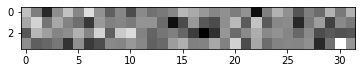

In [145]:
generated_latents = reverse_diffusion(unet, 8, 20)
plt.imshow(generated_latents[2].numpy().reshape(4, 4 * 8), cmap='gray')

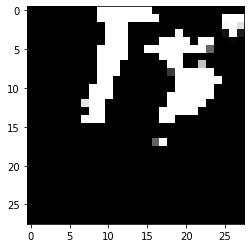

In [151]:
generated_latents = reverse_diffusion(unet, 2, 20)
generated_images = vae.decode(generated_latents)
plt.imshow(generated_images[0].numpy().reshape(28, 28), cmap='gray')